<a href="https://colab.research.google.com/github/jasreman8/LLMs-For-RAGs-II/blob/main/Foundational_Multimodal_Document_Parsing_and_Indexing_with_LlamaParse_and_LangChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives

- Parse a multimodal source document using `llamaparse` (from LlamaCloud).
- Index these sources to a vector database (Chroma) using `langchain` abstractions.

# Setup

!pip install -q openai==1.66.3 \
                tiktoken==0.9.0 \
                pypdf==5.4.0 \
                langchain==0.3.20 \
                langchain-community==0.3.19 \
                langchain-chroma==0.2.2 \
                langchain-openai==0.3.9 \
                chromadb==0.6.3 \
                lark==1.2.2 \
                llama-index-core==0.12.29 \
                llama-parse==0.6.4.post1 \
                llama-index-readers-file==0.4.7

In [2]:
import base64 # encodding images
import chromadb #vector database
import time, os

from openai import OpenAI

from langchain.text_splitter import RecursiveCharacterTextSplitter # helps us break documents into manageable chunks

from langchain_openai import OpenAIEmbeddings # text to vector representations
from langchain_chroma import Chroma # store vector representations

from llama_parse import LlamaParse # helps extract structured data from PDF documents.

from google.colab import userdata

import warnings
from pydantic.warnings import UnsupportedFieldAttributeWarning

warnings.filterwarnings("ignore", category=UnsupportedFieldAttributeWarning)

# RecursiveCharacterTextSplitter is a tool used to split text into chunks of manageable sizes, ...
# ... typically for the purpose of tokenization or preprocessing before passing it to models like GPT.

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(


In [3]:
import nest_asyncio; nest_asyncio.apply() #handle asynchronous functions properly

To facilitate parsing of multimodal pdf files, we use `llamaparse` hosted on LlamaCloud. Before parsing, ensure that you create a LlamaCloud API key.   

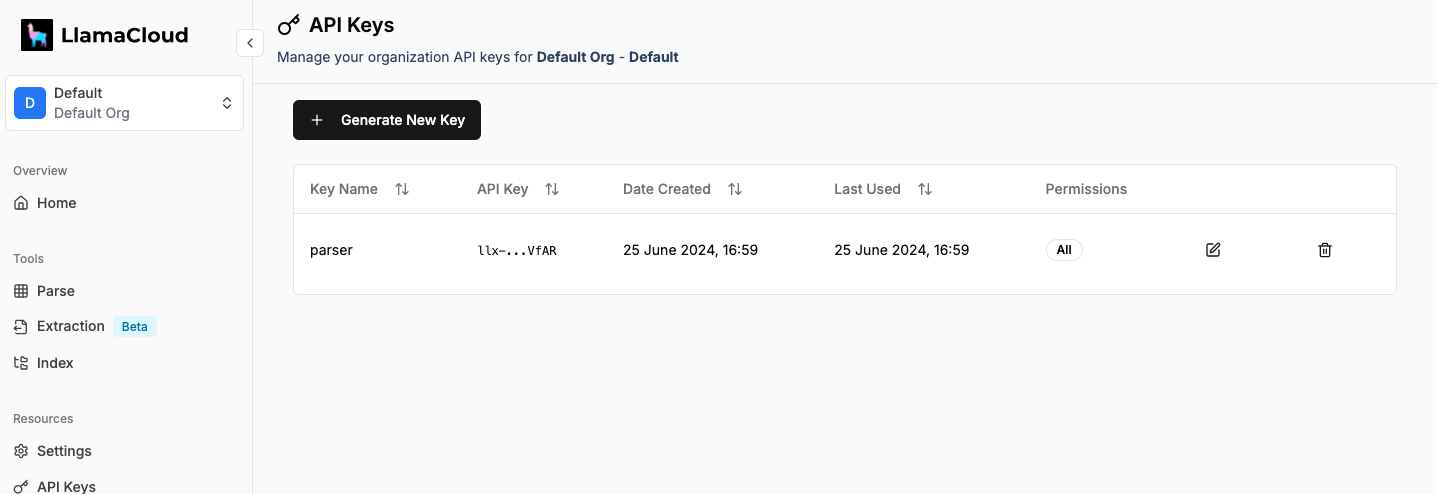

This API key can then be pasted into the userdata of Colab and used just like we have used Open AI API keys.

In [4]:
openai_api_key = userdata.get('my_api_key')
llamaparse_api_key = userdata.get('llamaparse_api_key')
os.environ["ANONYMIZED_TELEMETRY"] = "False"

In [5]:
client = OpenAI(
    api_key=openai_api_key,
)

In [6]:
#Embedding model is created to convert it to vector representations that can be searched efficently.
embedding_model = OpenAIEmbeddings(
    api_key=openai_api_key,
    model='text-embedding-3-small'
)

In [7]:
model_name = 'gpt-4o-mini'

# Parse

To illustrate parsing, let us extract the text, images and tables of an Dell XPS13 owners manual. Note that the parser uploads this pdf file onto LlamaCloud where we can track progress of the parsing job.

In [8]:
pdf_file_path = 'xps-13-9340-owners-manual-en-us.pdf'

In [9]:
parser = LlamaParse(
    result_type="markdown", # to get structured output
    skip_diagonal_text=True,
    fast_mode=False, # for more accurate parsing
    num_workers=9,
    check_interval=10,
    api_key=llamaparse_api_key
)

In [10]:
json_objs = parser.get_json_result(pdf_file_path)

Started parsing the file under job_id 9530d023-1a0d-4149-9a64-d929dbe797e7


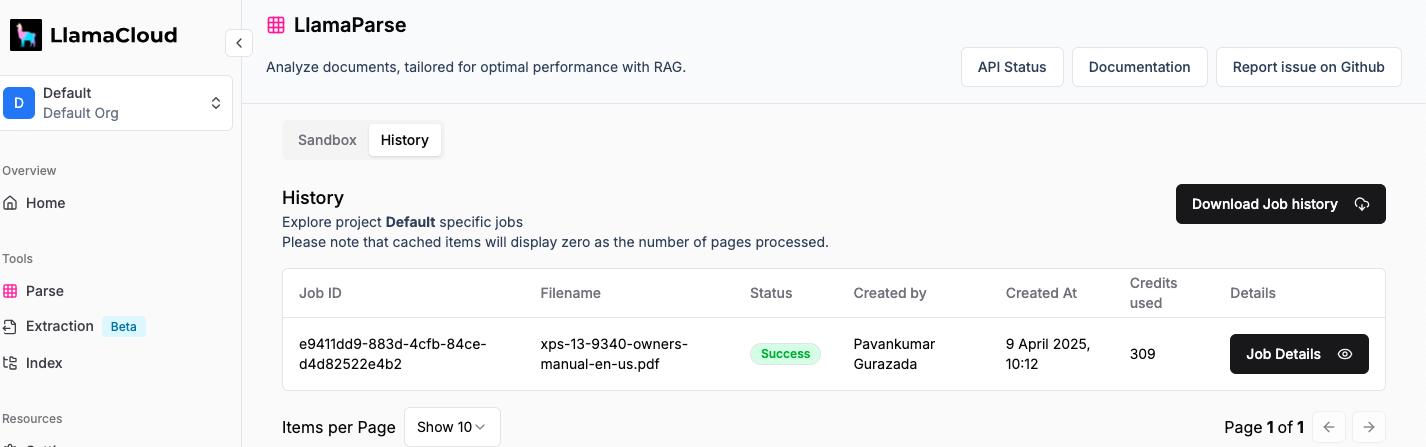

Clicking on Job Details, we can view the different elements of the pdf file that was parsed.

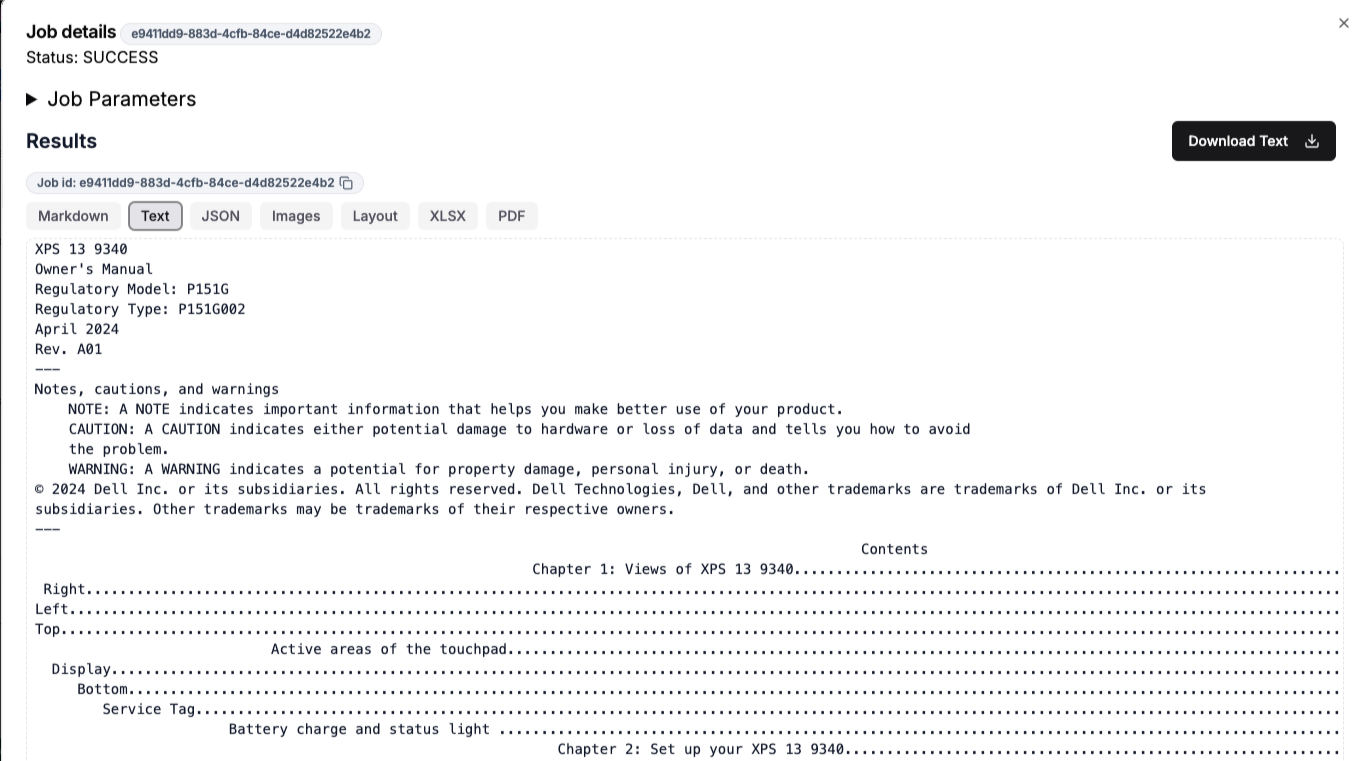

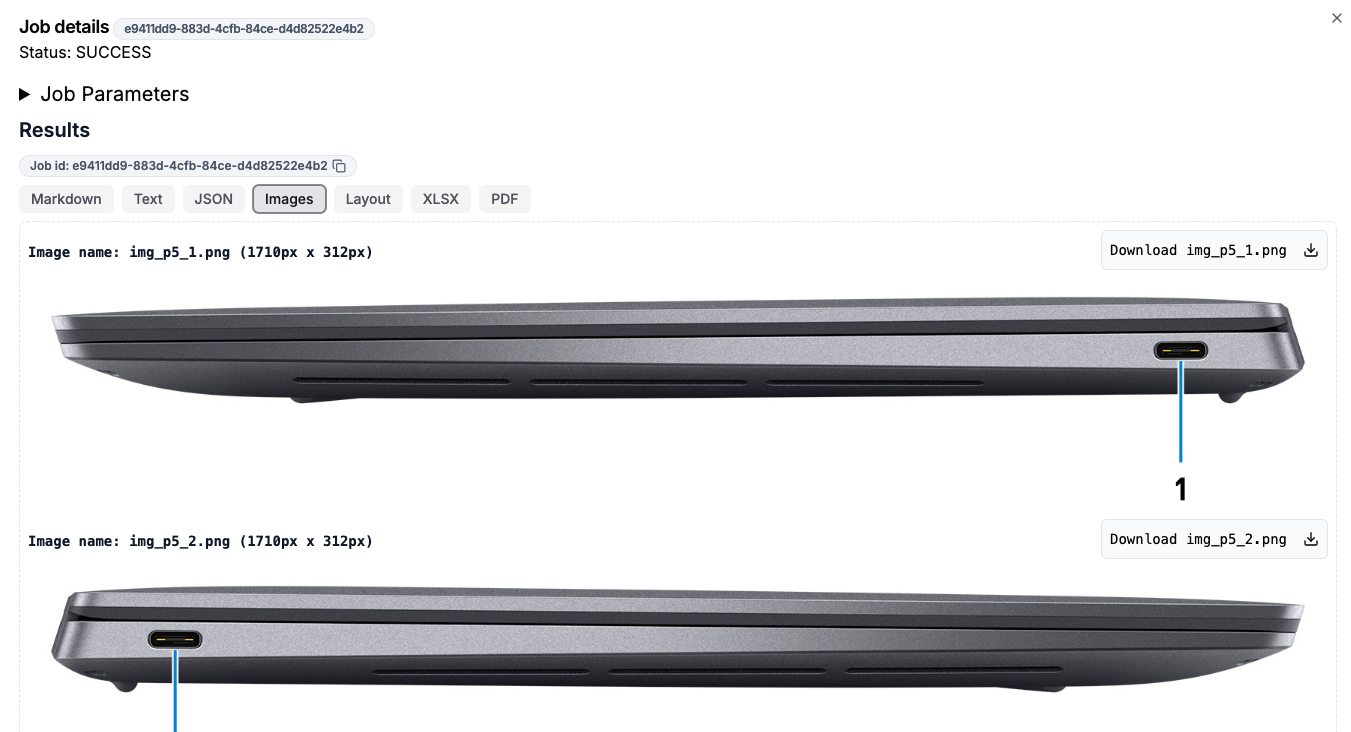

The output from the parser is a list of JSON objects containing the pages in the document. Let us inspect a sample object to understand its structure.

In [11]:
type(json_objs)

list

In [12]:
json_objs[0]['pages'][7]
# looking at a page to understand the structure of parsing

{'page': 8,
 'text': '   5.     Service LED\n          The service LED is used for troubleshooting with a Dell service representative. The LED emits amber or white light.\n\n   Active areas of the touchpad\n\n esc  F1  F2  F3  F4  F5  F6  F7  F8  F9  F10  F11  F12  delete\n\n ~  !  @  #  $  %  ^  &  *  (   )  -  +  backspace\n 1  2  3  4  5  6  7  8  9   0  =\n\n tab  Q  W  E  R  T  Y  U  |  O  P  {  }  |\n [  ]  \\\n\n caps lock  A  S  D  F  G  H  J  K  L  :  “  enter\n -  ;\n\n shift  Z  X  C  V  B  N  M  <  >  ?  shift\n ,\n\n ctrl  fn  II  alt  alt  O  <  ^ pg  J\n 0  Vpg\n\njasreman8@gmail.com\nY96VNKLF1X\n\n                                          1    2\n\n   Figure 4. Active areas of the touchpad\n\n   1.     Left-click area of the touchpad\n          Move your finger on the touchpad within this area to control the cursor. Tap this area to left-click.\n   2.     Right-click area of the touchpad\n          Move your finger on the touchpad within this area to control the cursor.

As the above output indicates, `llamaparse` extracts the different elements of the document pagewise. Of particular interest to us is the text of the pages, stored under the key `md` and `text`. Images get their own key: `images`, while tables are stored as `items` of type `table`.

Let us now extract all the text and tables in the document by looping over the extracted pages.

In [13]:
pages_list = json_objs[0]["pages"]

## Extract Text

We begin by collecting all the text in the pages into a list by page.

In [14]:
page_texts = []

for json_item in pages_list:
    current_page_text = f"Page {json_item['page']}: \n" + json_item['md'] + '\n'
    page_texts.append(current_page_text)

In [15]:
len(page_texts)

103

Let us now inspect a page.

In [16]:
page_texts[14]

'Page 15: \n\n\n# Chipset\n\nThe following table lists the details of the chipset that is supported for your XPS 13 9340.\n\n| Description    | Values                      |\n| -------------- | --------------------------- |\n| Chipset        | Integrated in the processor |\n| Processor      | Intel Core Ultra 5/7        |\n| DRAM bus width | 128-bit                     |\n| Flash EPROM    | 64 MB                       |\n| PCIe bus       | Up to Gen4                  |\n\n# Operating system\n\nYour XPS 13 9340 supports the following operating systems:\n\n- Windows 11 Pro\n- Windows 11 Pro National Education\n- Windows 11 Home\n- Ubuntu Linux 22.04 LTS\n\n# Memory\n\nThe following table lists the memory specifications of your XPS 13 9340.\n\n| Description                                                                | Values                                                                                                                                                                    

## Generate Table Descriptions

In [17]:
tables = {}

In [18]:
for json_item in pages_list: # iterates through each page in the pages_list
    current_title = None # initializes current_title to None for each page
    for component in json_item['items']: # iterates through each component (e.g., heading, table) within a page
        if component['type'] == 'heading' and 'Table' in component['value']: # checks if the component is a heading and contains the word "Table"
            current_title = component['value'] # if true, assigns the heading value to current_title
        elif component['type'] == 'table' and current_title: # checks if the component is a table and current_title is not None (meaning a valid heading was found)
            tables[current_title] = component['rows'] # if true, adds the table data to the tables dictionary using current_title as the key
            current_title = None # resets current_title to None to avoid adding subsequent tables with the same title

Let us begin by inspecting specific tables that we extracted (corresponding to Table 16, 17 and 19 in the document).

In [19]:
len(tables.keys())

28

In [20]:
print(tables['Table 16. Power adapter specifications'])

[['Description', 'Values'], ['Type', '60 W AC adapter, USB Type-C'], ['Power-adapter dimensions:', ''], ['Height', '22 mm (0.87 in.)'], ['Width', '55 mm (2.17 in.)'], ['Depth', '66 mm (2.60 in.)'], ['Input voltage', '100 VAC–240 VAC'], ['Input frequency', '50 Hz–60 Hz'], ['Input current (maximum)', '1.70 A'], ['Output current (continuous)', '3 A'], ['Rated output voltage', '● 20 VDC ● 15 VDC']]


In [21]:
print(tables['Table 17. Battery specifications'])

[['Description', 'Values'], ['Battery type', '3-cell, 55 Wh "smart" lithium-ion'], ['Battery voltage', '11.55 VDC'], ['Battery weight (maximum)', '0.219 kg (0.483 lb)'], ['Battery dimensions:', ''], ['Height', '238.40 mm (9.39 in.)'], ['Width', '4.86 mm (0.19 in.)'], ['Depth', '97.41 mm (3.84 in.)'], ['Temperature range:', ''], ['Operating', '0°C to 65°C (32°F to 149°F)'], ['Storage', '-20°C to 65°C (-4°F to 149°F)'], ['Battery operating time', 'Varies depending on operating conditions and can significantly reduce under certain power-intensive conditions.'], ['Battery charging time (approximate)', '3 hours (when the computer is off)']]


In [22]:
print(tables['Table 19. Fingerprint reader specifications'])

[['Description', 'Values'], ['Fingerprint-reader sensor technology', 'Trans-capacitive sensing'], ['Fingerprint-reader sensor resolution', '500 dpi'], ['Fingerprint-reader sensor pixel size', '88 x 108']]


We now need to describe the rows of this table as text to capture the contents of the table. Let us execute this logic on one table before rolling out to all the tables in the document.

In [23]:
table_describer_system_message = """
You are tasked to explain operating manual documents for Dell laptops.
You are required to generate a detailed description of rows of tables presented to you as the input.
Be detailed in your description and describe ALL the rows of the table presented to you.
The input will contain the title of the table followed by a list of rows in the table.
Remember to include the title of the table in your output.
Do not add any text other than the title and the description of the table in your output.
"""

In [24]:
# Generating the description of a sample table

table_key = 'Table 16. Power adapter specifications'

table_description_prompt = [
    {'role': 'developer', 'content': table_describer_system_message},
    {'role': 'user', 'content': table_key + str(tables[table_key])}
]


In [25]:
try:
    response = client.chat.completions.create(
        model=model_name,
        messages=table_description_prompt,
        temperature=0
    )
    description = response.choices[0].message.content
except Exception as e:
    description = ''

In [26]:
print(description)

Table 16. Power adapter specifications

This table provides detailed specifications for the power adapter used with Dell laptops. It consists of two columns: 'Description' and 'Values', which outline various attributes of the power adapter.

- The first row describes the 'Type' of the adapter, which is a "60 W AC adapter, USB Type-C". This indicates that the adapter is capable of delivering 60 watts of power and utilizes a USB Type-C connection.

- The second row is labeled 'Power-adapter dimensions:', but it does not contain any values. This suggests that the following rows will provide specific measurements related to the dimensions of the adapter.

- The third row specifies the 'Height' of the adapter, which is 22 mm (0.87 in.). This measurement indicates how tall the adapter is.

- The fourth row provides the 'Width' of the adapter, measuring 55 mm (2.17 in.). This dimension indicates how wide the adapter is.

- The fifth row lists the 'Depth' of the adapter, which is 66 mm (2.60 i

Let us now roll out this description generator to all the tables in the document.

In [27]:
def generate_table_description(tables, table_key):
    """Generates a description of a table using an OpenAI model.

    This function takes a dictionary of tables and a table key as input. It then
    constructs a prompt containing a system message and the table data.
    This prompt is sent to an OpenAI model, and the model's response is returned as
    the table description.

    Args:
        tables: A dictionary of tables.
        table_key: The key of the table to describe.

    Returns:
        A string containing the description of the table. If an error occurs
        during the OpenAI API call, an empty string is returned.
    """

    table_description_prompt = [
        {'role': 'developer', 'content': table_describer_system_message},
        {'role': 'user', 'content': table_key + str(tables[table_key])}
    ]

    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=table_description_prompt,
            temperature=0
        )
        description = response.choices[0].message.content
        return description
    except Exception as e:
        description = ''
        return description

In [28]:
table_descriptions = [generate_table_description(tables, table_key) for table_key in tables.keys()]

In [29]:
assert len(table_descriptions) == len(tables.keys())

In [30]:
table_descriptions[3]

'Table 13. List of keyboard shortcuts\n\nThis table provides a comprehensive list of keyboard shortcuts available on Dell laptops, detailing the specific key combinations and their corresponding behaviors.\n\n- The first row lists the header "Keyboard shortcut" and "Behavior," indicating the two main categories of information presented in the table.\n- The second row features the shortcut "Copilot," which is used to launch Copilot in Windows.\n- The third row contains a note stating that if Copilot in Windows is not available on the user\'s computer, the Copilot key will instead launch Windows Search. It also advises users to search in the Knowledge Base Resource at the Dell Support Site for more information about Copilot in Windows.\n- The fourth row shows the "fn" key, which is used to switch between modes of the capacitive touch panel.\n- The fifth row lists the shortcut "fn + B," which is designated for the action of pausing.\n- The sixth row presents "fn + S," which toggles the sc

## Generate Image Descriptions

Let us begin by downloading all the images.

In [31]:
image_dicts = parser.get_images(
    json_objs,
    download_path="dellxps_images"
)

> Images for page 1: []
> Images for page 2: []
> Images for page 3: []
> Images for page 4: []
> Images for page 5: []
> Images for page 6: [{'name': 'img_p5_1.jpg', 'height': 74.88, 'width': 410.4, 'x': 92.438, 'y': 192.598, 'original_width': 1710, 'original_height': 312, 'rotation': 0, 'ocr': [{'x': 1623, 'y': 284, 'w': 27, 'h': 35, 'confidence': 1, 'text': '1'}]}, {'name': 'img_p5_2.jpg', 'height': 74.88, 'width': 410.4, 'x': 92.438, 'y': 464.544, 'original_width': 1710, 'original_height': 312, 'rotation': 0}]
> Images for page 7: [{'name': 'img_p6_1.jpg', 'height': 356.867, 'width': 521.576, 'x': 36.85, 'y': 101.436, 'original_width': 1710, 'original_height': 1170, 'rotation': 0, 'ocr': [{'x': 831, 'y': 1115, 'w': 37, 'h': 50, 'confidence': 1, 'text': '4'}, {'x': 1368, 'y': 660, 'w': 25, 'h': 20, 'confidence': 0.999, 'text': 'pg'}, {'x': 1163, 'y': 660, 'w': 18, 'h': 15, 'confidence': 0.693, 'text': '0'}, {'x': 1341, 'y': 658, 'w': 16, 'h': 14, 'confidence': 0.519, 'text': 'V'}, {

Let us now look at the information available about a specific image.

In [32]:
image_dicts[0]

{'name': 'img_p5_1.jpg',
 'height': 74.88,
 'width': 410.4,
 'x': 92.438,
 'y': 192.598,
 'original_width': 1710,
 'original_height': 312,
 'rotation': 0,
 'ocr': [{'x': 1623,
   'y': 284,
   'w': 27,
   'h': 35,
   'confidence': 1,
   'text': '1'}],
 'path': 'dellxps_images/9530d023-1a0d-4149-9a64-d929dbe797e7-img_p5_1.jpg',
 'job_id': '9530d023-1a0d-4149-9a64-d929dbe797e7',
 'original_file_path': 'xps-13-9340-owners-manual-en-us.pdf',
 'page_number': 6}

Let us now generate a detailed description of this sample image. We will use GPT 4o mini for this task.

In [33]:
sample_image_path = image_dicts[0]['path']

In [34]:
def image_describer(image_file_path):
    """Generates a detailed description of an image using GPT-4o-mini.

    This function takes the file path of an image as input, reads the image data,
    encodes it to base64, and constructs a data URI. It then sends a prompt
    containing the image data URI to GPT-4o-mini. The model's
    response, which contains a detailed description of the image, is returned.

    Args:
        image_file_path: The file path of the image to describe.

    Returns:
        A string containing the description of the image generated by OpenAI
        GPT-4o-mini.
    """

    with open(image_file_path, 'rb') as image_file:
        image_data = image_file.read()

    # Encode the binary image data to base64
    base64_encoded_data = base64.b64encode(image_data).decode('utf-8')

    # Construct the data URI
    data_uri = f"data:image/png;base64,{base64_encoded_data}"

    image_description_system_message = """
    You are tasked to explain images present in the operating manual for Dell laptops.
    You are required to generate detailed description on key objects from the image presented to you as the input.
    Be detailed in your description and describe the image presented to you.
    Do not add any text other than the description of the image in your output.
    """

    image_description_prompt = [
        {
            'role': 'system',
            'content': image_description_system_message
        },
        {
            'role': 'user',
            'content': [
                {'type': "image_url", "image_url": {'url': data_uri}}
            ]
        }
    ]

    response = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=image_description_prompt,
        temperature=0
    )

    return response.choices[0].message.content

In [35]:
image_describer(sample_image_path)

'The image shows a side view of a Dell laptop, highlighting a specific port. The laptop has a sleek, metallic gray finish. On the right side, there is a USB Type-C port, which is marked with a number "1" pointing to it. The port has a rectangular shape with rounded edges and features a small yellow interior, indicating its functionality for data transfer and charging. The laptop\'s body has a smooth surface with subtle lines and ventilation slots visible beneath the port, suggesting a design that promotes airflow. The overall design is modern and minimalist, typical of contemporary laptop aesthetics.'

We can now loop over all the paths of the downloaded images and create descriptions of these images.

In [36]:
from openai import RateLimitError

def safe_image_describer(path, retries=5):
    for attempt in range(retries):
        try:
            return image_describer(path)
        except RateLimitError:
            sleep_time = 2 ** attempt
            time.sleep(sleep_time)
    raise RuntimeError("Max retries exceeded")

image_descriptions = []
for image_info in image_dicts:
    desc = safe_image_describer(image_info["path"])
    image_descriptions.append(desc)

In [37]:
# image_descriptions = []

# for image_info in image_dicts:
#     image_descriptions.append(
#         image_describer(image_info["path"])
#     )
#     time.sleep(0.3)  # throttle calls

In [38]:
len(image_descriptions)

70

# Chunk and Index

Before chunking and indexing, let us collect all the text, table and image descriptions as single block of texts.

In [39]:
page_texts[0]

"Page 1: \n\n# XPS 13 9340\n\n# Owner's Manual\n\njasreman8@gmail.com\n\nY96VNKLF1X\n\nRegulatory Model: P151G\n\nRegulatory Type: P151G002\n\nApril 2024\n\nRev. A01\n\nThis file is meant for personal use by jasreman8@gmail.com only.\n\nSharing or publishing the contents in part or full is liable for legal action.\n\n\n"

In [40]:
full_text = ''

for text in page_texts:
    full_text += ('\n---\n' + text)

In [41]:
all_table_descriptions = ''

for description in table_descriptions:
    all_table_descriptions += ('\n---\n' + description)

In [42]:
all_image_descriptions = ''

for description in image_descriptions:
    all_image_descriptions += ('\n---\n' + description)

In [43]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=512,
    chunk_overlap=16
)

In [44]:
all_chunks = text_splitter.create_documents(
    [full_text, all_table_descriptions, all_image_descriptions],
    metadatas=[{'source': 'text'}, {'source': 'table_descriptions'}, {'source': 'image_descriptions'}]
)

In the code above, note that we are adding the source of the text (i.e., document text, table or image) as metadata.

In [45]:
dell_collection = 'xps13-owners-manual'

In [46]:
chromadb_client = chromadb.PersistentClient(
    path="./dell_db"
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given


In [47]:
vectorstore = Chroma(
    collection_name=dell_collection,
    collection_metadata={"hnsw:space": "cosine"},
    embedding_function=embedding_model,
    client=chromadb_client,
    persist_directory="./dell_db"
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [48]:
chromadb_client.count_collections()

1

In [49]:
chromadb_client.list_collections()

['xps13-owners-manual']

In [50]:
len(all_chunks)

143

In [51]:
vectorstore.add_documents(
    documents=all_chunks,
    ids=['text_' + str(i) for i in range(len(all_chunks))]
)

['text_0',
 'text_1',
 'text_2',
 'text_3',
 'text_4',
 'text_5',
 'text_6',
 'text_7',
 'text_8',
 'text_9',
 'text_10',
 'text_11',
 'text_12',
 'text_13',
 'text_14',
 'text_15',
 'text_16',
 'text_17',
 'text_18',
 'text_19',
 'text_20',
 'text_21',
 'text_22',
 'text_23',
 'text_24',
 'text_25',
 'text_26',
 'text_27',
 'text_28',
 'text_29',
 'text_30',
 'text_31',
 'text_32',
 'text_33',
 'text_34',
 'text_35',
 'text_36',
 'text_37',
 'text_38',
 'text_39',
 'text_40',
 'text_41',
 'text_42',
 'text_43',
 'text_44',
 'text_45',
 'text_46',
 'text_47',
 'text_48',
 'text_49',
 'text_50',
 'text_51',
 'text_52',
 'text_53',
 'text_54',
 'text_55',
 'text_56',
 'text_57',
 'text_58',
 'text_59',
 'text_60',
 'text_61',
 'text_62',
 'text_63',
 'text_64',
 'text_65',
 'text_66',
 'text_67',
 'text_68',
 'text_69',
 'text_70',
 'text_71',
 'text_72',
 'text_73',
 'text_74',
 'text_75',
 'text_76',
 'text_77',
 'text_78',
 'text_79',
 'text_80',
 'text_81',
 'text_82',
 'text_83',
 '

In [52]:
collection = chromadb_client.get_collection(dell_collection)

In [53]:
collection.peek(limit=3)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given


{'ids': ['text_0', 'text_1', 'text_2'],
 'embeddings': array([[ 0.0470525 ,  0.00517552,  0.02485527, ...,  0.00661316,
         -0.02008868, -0.00586559],
        [ 0.03894213, -0.0042079 ,  0.0268324 , ...,  0.0165398 ,
         -0.01415233,  0.00957637],
        [ 0.04697531,  0.01511677,  0.01366927, ...,  0.00691315,
         -0.01175066, -0.01487096]]),
 'documents': ["---\nPage 1: \n\n# XPS 13 9340\n\n# Owner's Manual\n\njasreman8@gmail.com\n\nY96VNKLF1X\n\nRegulatory Model: P151G\n\nRegulatory Type: P151G002\n\nApril 2024\n\nRev. A01\n\nThis file is meant for personal use by jasreman8@gmail.com only.\n\nSharing or publishing the contents in part or full is liable for legal action.\n\n\n\n---\nPage 2: \n# Notes, cautions, and warnings\n\n# NOTE\n\nA NOTE indicates important information that helps you make better use of your product.\n\n# CAUTION\n\nA CAUTION indicates either potential damage to hardware or loss of data and tells you how to avoid the problem.\n\n# WARNING\n\nA WA

# Query

In [54]:
vectorstore_persisted = Chroma(
    collection_name=dell_collection,
    collection_metadata={"hnsw:space": "cosine"},
    embedding_function=embedding_model,
    client=chromadb_client,
    persist_directory="./dell_db"
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [55]:
retriever = vectorstore_persisted.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

In [56]:
user_query = "The LED on my adapter is white. What does this mean?"

In [57]:
retriever.invoke(user_query)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


[Document(id='text_99', metadata={'source': 'table_descriptions'}, page_content='- The fourth row provides the \'Width\' of the adapter, measuring 55 mm (2.17 in.). This dimension shows how wide the adapter is.\n\n- The fifth row lists the \'Depth\' of the adapter, which is 66 mm (2.60 in.). This measurement indicates how deep the adapter is.\n\n- The sixth row details the \'Input voltage\', which ranges from 100 VAC to 240 VAC. This indicates the voltage range the adapter can accept from a power source.\n\n- The seventh row specifies the \'Input frequency\', which is between 50 Hz and 60 Hz. This indicates the frequency of the electrical current the adapter can handle.\n\n- The eighth row outlines the \'Input current (maximum)\', which is 1.70 A. This indicates the maximum current the adapter can draw from the power source.\n\n- The ninth row describes the \'Output current (continuous)\', which is 3 A. This indicates the continuous current the adapter can provide to the laptop.\n\n- T